In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from collections import Counter

np.random.seed(3116)

Exercise 1: Exploring Movie Recommendation Datase

In [2]:
#Load data
data=pd.read_csv('u.data',sep='\t', header=None)
genre=pd.read_csv('u.genre',sep='|', header=None)
user=pd.read_csv('u.user',sep='|', header=None)
item=pd.read_csv('u.item', sep='|', header=None, encoding='latin-1')

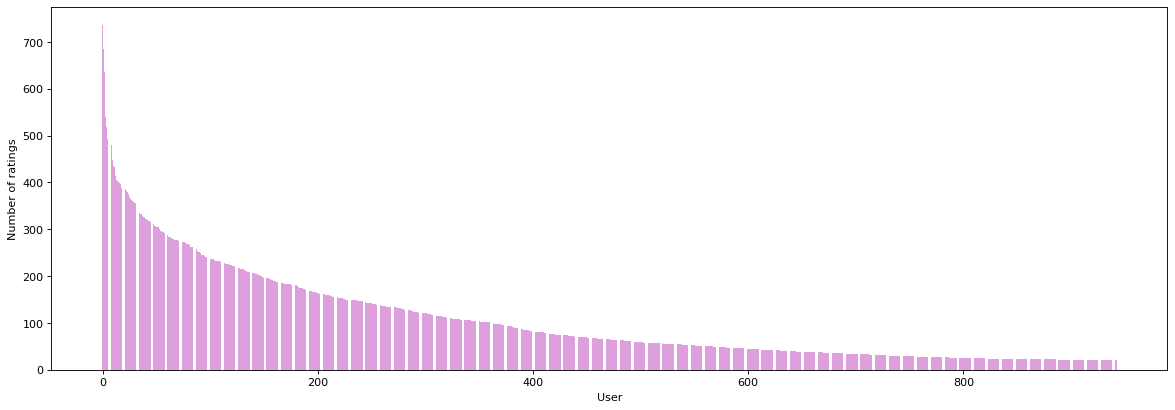

In [3]:
#Showcase how the ratings vary across users.

user_counts=Counter(data[0]) #Find how many times each user appears

n_ratings = np.array(list(user_counts.values())) #Get data as array
i = np.argsort(n_ratings) #Organize data

#Plot
figure(figsize=(18, 6), dpi=80)
plt.bar(list(range(len(n_ratings))),n_ratings[i[::-1]], color='plum')
plt.xlabel('User')
plt.ylabel('Number of ratings')
plt.show()

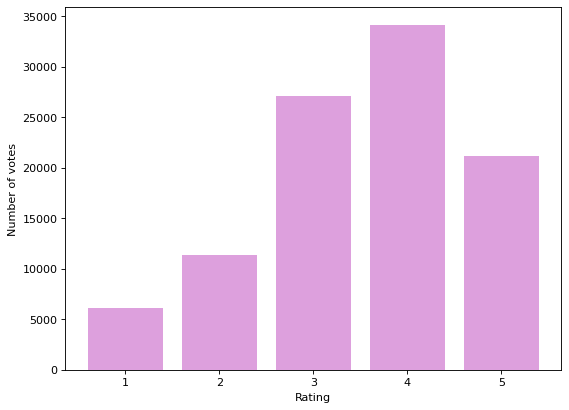

In [4]:
#Showcase how the ratings vary across items
rating_counts=Counter(data[2]) #Count ratings

ratings = np.array(list(rating_counts.keys()))
i = np.argsort(ratings) #Sort by rating value
votes=np.array(list(rating_counts.values()))

#Plot
figure(figsize=(8, 6), dpi=80)
plt.bar(list(range(1,6)),votes[i], color='plum')
plt.xlabel('Rating')
plt.ylabel('Number of votes')
plt.show()

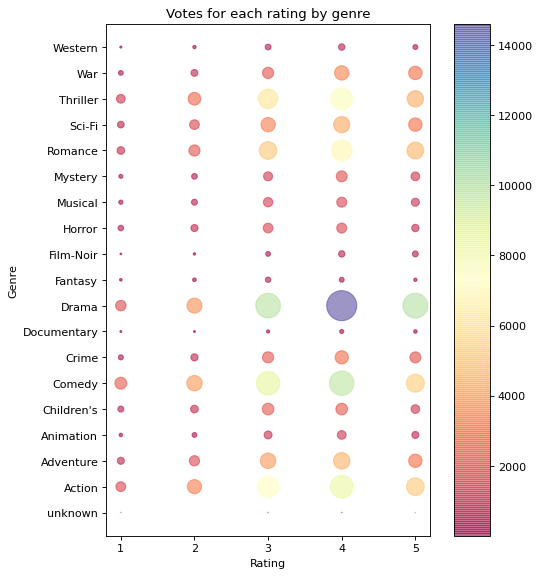

In [5]:
#Are there genres that are more highly rated than others?

order=np.array(data[1]) #Get order of movies in data
data_by_genre=np.array(item.iloc[order-1,np.array(range(5,24))]) #Get genre data for movies

rating=np.array(data[2]) #Get ratings

ratings_of_genres=np.multiply(np.array(data_by_genre).T,np.array(rating))#Get ratings for each genre

votes_for_genre=[]
for i in range(len(ratings_of_genres)):
  counts=Counter(ratings_of_genres[i]) #Count votes for each rating possibility
  votes_for_genre.append(counts)

votes_by_genre=pd.DataFrame.from_dict(votes_for_genre).sort_index(axis=1).drop(axis=1,columns=0) #Put the information in dataset
votes_by_genre['genre']=np.array(genre[1]) #Add genre column
votes_by_genre=votes_by_genre.melt(id_vars=['genre'], value_vars=[1,2,3,4,5]) #Reorganize data

#Plot
figure(figsize=(6, 8), dpi=80)

plt.scatter(votes_by_genre['variable'],votes_by_genre['genre'],s=votes_by_genre['value']*0.05,c=votes_by_genre['value'],alpha=0.6,cmap='Spectral')
labels = list(genre[0])
plt.yticks(ticks=list(genre[1]), labels=list(genre[0]))
plt.xticks([1,2,3,4,5])
plt.title('Votes for each rating by genre')
plt.xlabel('Rating')
plt.ylabel('Genre')

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)

plt.show()

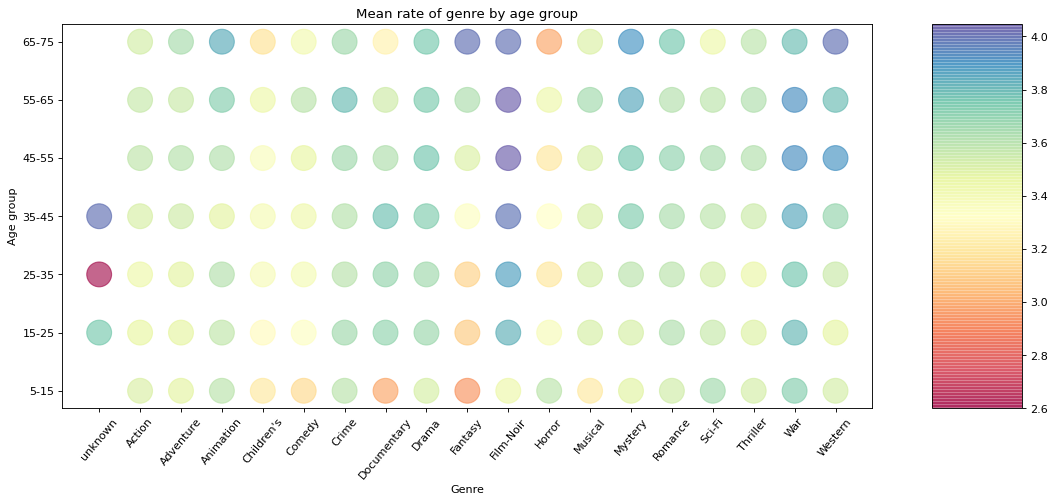

In [6]:
#What age groups prefer what genres based on ratings

order=np.array(data[0])#Get order of users
ages=user.iloc[order-1,1] #Get ages in order
ages=pd.cut(ages, bins=[5,15,25,35,45,55,65,75],labels=['5-15','15-25','25-35','35-45','45-55','55-65','65-75']) #Create bins for ages
ratings_of_genres=pd.DataFrame(ratings_of_genres.T) #Get ratings for genres 
ratings_of_genres.replace(0, np.nan,inplace=True) #Ignore non voted elements


ratings_of_genres['ages']=np.array(ages) #Add ages column

mean_by_age=ratings_of_genres.groupby(['ages']).mean() #Get mean for each age and genre
mba=mean_by_age.reset_index()

mba=mba.melt(id_vars=['ages'], value_vars=np.arange(len(genre)),value_name='rate') #Reorganize data
mba['ages_id']=mba['ages'].replace(['5-15','15-25','25-35','35-45','45-55','55-65','65-75'], np.arange(7)) #Replace names for bins

#Plot
figure(figsize=(15, 6), dpi=80)

plt.scatter(mba['variable'],mba['ages_id'],s=500,c=mba['rate'],alpha=0.6,cmap='Spectral')

plt.yticks(ticks=np.arange(7), labels=['5-15','15-25','25-35','35-45','45-55','55-65','65-75'])
plt.xticks(ticks=list(genre[1]), labels=list(genre[0]),rotation=50)
plt.title('Mean rate of genre by age group')
plt.xlabel('Genre')
plt.ylabel('Age group')

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)



Exercise 2: Implementing basic matrix factorization (MF) technique
for recommender systems

In [7]:
#Get data matrix of users x movies
data_vector=data.rename(columns={0: "user", 1: "movie", 2: 'rating'})
data_matrix=np.array(data_vector.pivot_table(values='rating', index='movie', columns='user').replace(np.nan, 0))

In [8]:
#Get indexes of instances splitted
train_vector=data_vector.iloc[0:round(len(data)*0.8)]
valid_vector=data_vector.iloc[round(len(data)*0.8):round(len(data_vector)*0.9)]
test_vector=data_vector.iloc[round(len(data)*0.9):]

In [9]:
#Get matrixes for train, test and test
data_matrix=np.array(data_vector.pivot_table(values='rating', index='movie', columns='user').replace(np.nan, 0))
train_positions=np.array(train_vector[['user','movie']])-1
validation_positions=np.array(valid_vector[['user','movie']])-1
test_positions=np.array(test_vector[['user','movie']])-1

train_data_matrix=data_matrix.copy()
train_data_matrix[validation_positions]=0
train_data_matrix[test_positions]=0

In [10]:
def get_norm_params(x):
  dfx=pd.DataFrame(x).replace(0, np.nan)
  mean=np.nanmean(np.array(dfx))
  std=np.nanstd(np.array(dfx))
  return mean,std

#Normalize data
def normalize(x,mean,std):
  return (x-mean)/std

In [11]:
def rmse(y, yhat):
  return np.sum(np.sqrt((y-yhat)**2) ) /len(y)

In [12]:
#I used this as a guidance https://everdark.github.io/k9/notebooks/ml/matrix_factorization/matrix_factorization.nb.html

def matrix_factorization(valid_vector,train_vector,train_data_matrix,alpha,l,k,eps=0.001,max_iter=50):
  #Normalize input
  m,s=get_norm_params(data_matrix)
  train_data_matrix=normalize(train_data_matrix,m,s)


  #Random initialization
  p=np.random.normal(0,s,[len(train_data_matrix),k])
  q=np.random.normal(0,s,[len(train_data_matrix[0]),k])

  train_errors=[]
  rmse_errors=[]
  for j in range(max_iter):
    errors=[]
    for i in range(len(train_vector)):
      col=train_vector.iloc[i,0]-1
      row=train_vector.iloc[i,1]-1
      prediction=p[row,:]@q[col,:]

      #Calculate error from prediction
      error=normalize(train_vector.iloc[i,2],m,s)-prediction
      errors.append(error)

      for j in range(k):
        #Update p and q
        p[row,j]=p[row,j]+alpha*(error*q[col,j]-l*p[row,j])
        q[col,j]=q[col,j]+alpha*(error*p[row,j]-l*q[col,j])    
    
    train_errors.append(np.mean(np.array(errors)))

    #Get original matrix reconstruction and predictions for validation
    reconstruction=p@q.T
    validation_positions=np.array(valid_vector[['user','movie']])

    valid_predictions=[]
    for i in range(len(validation_positions)):
      valid_predictions.append(reconstruction[validation_positions[i,1]-1,validation_positions[i,0]-1])

    #Calculate rmse on validation
    rmse_error=rmse(np.array(valid_predictions), normalize(np.array(valid_vector['rating']),m,s))
    rmse_errors.append(rmse_error)

    if rmse_error<eps:
      return p, q, rmse_errors, train_errors

  return p, q, rmse_errors, train_errors



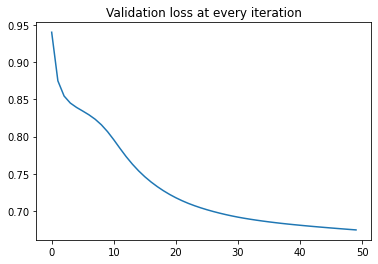

In [13]:
alpha=0.01
l=0.1
eps=0.001
k=3
max_iter=50

p,q,rmse_err,train_err=matrix_factorization(valid_vector,train_vector,train_data_matrix,alpha,l,k,eps,max_iter)

plt.plot(np.arange(len(rmse_err)),rmse_err)
plt.title('Validation loss at every iteration')
plt.show()

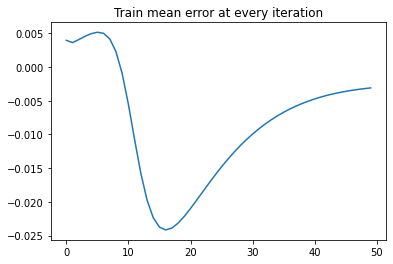

In [14]:
plt.plot(np.arange(len(train_err)),train_err)
plt.title('Train mean error at every iteration')
plt.show()

In [15]:
params = {'alpha': [0.01, 0.001, 0.0001], 'l': [0.1, 0.01, 0.001], 'k': [3, 5, 7]}

In [16]:
#Do random search to optimize hyperparameters
params_combinations = 7
params_hist=[]
losses=[]

for i in range(params_combinations):
  print(i)
  a=params['alpha'][np.random.randint(len(params['alpha']))]
  l=params['l'][np.random.randint(len(params['l']))]
  k=params['k'][np.random.randint(len(params['k']))]

  p,q,rmse_err,train_err=matrix_factorization(valid_vector,train_vector,train_data_matrix,a,l,k,0.01,20)
  losses.append(rmse_err)
  params_hist.append([a,k,l])


0
1
2
3
4
5
6


In [17]:
#Train with best params 
min_loss=np.inf
for i in range(len(losses)):
  min=np.min(losses[i])
  if min<min_loss:
    min_loss=min
    min_params=params_hist[i]

a,k,l=min_params
p,q,rmse_err,train_err=matrix_factorization(valid_vector,train_vector,train_data_matrix,a,l,k,0.01,20)

In [18]:
#Get reconstruction
reconstruction=p@q.T
validation_positions=np.array(valid_vector[['user','movie']])
test_positions=np.array(test_vector[['user','movie']])

#Get RMSE on validation and test data
valid_predictions=[]
test_predictions=[]
for i in range(len(validation_positions)):
  valid_predictions.append(reconstruction[validation_positions[i,1]-1,validation_positions[i,0]-1])

for i in range(len(test_positions)):
  test_predictions.append(reconstruction[test_positions[i,1]-1,test_positions[i,0]-1])

m1,s1=get_norm_params(np.array(valid_vector['rating']))
m2,s2=get_norm_params(np.array(test_vector['rating']))


rmse_validation_error=rmse(np.array(valid_predictions), normalize(np.array(valid_vector['rating']),m1,s1))
rmse_test_error=rmse(np.array(test_predictions), normalize(np.array(test_vector['rating']),m2,s2))

print(f'The rmse of validation was {rmse_validation_error}')
print(f'The rmse of test was {rmse_test_error}')

The rmse of validation was 0.7739848203712641
The rmse of test was 0.7800686603119272


Exercise 3: Recommender Systems using matrix factorization sckit-
learn 

I decided to use surprise because this is a library that easily implements matrix factorization for making predictions. Other algorithms have trouble with implementation when the dataset has many unknown values.

For the training, it tries to predict values based on the mean, bias values and the product of p and q, which are the factorization. It uses a loss function that takes the squared difference of the error, the squared biases and the squared norm of matrices p and q, it also has a term for regularization. P and q are randomly intialized based on std and mean.

My solution is based on the algorithm provided here https://surprise.readthedocs.io/en/stable/getting_started.html#tune-algorithm-parameters-with-gridsearchcv

In [50]:
from surprise import SVD
from surprise.model_selection import cross_validate, GridSearchCV
from surprise import Reader
from surprise import Dataset

from os.path import expanduser

In [51]:
#Import data as surprise dataset
file_path = expanduser('u.data')
reader = Reader(line_format='user item rating timestamp', sep='\t')
movies_data = Dataset.load_from_file(file_path, reader=reader)

In [54]:
#Define parameter grid
params={'n_factors': [10, 50], 'biased': [True, False], 'lr_all': [0.005, 0.001], 'reg_all': [0.01, 0.1]}

In [55]:
#Train model with 3 fold cross validation
model = GridSearchCV(SVD, params, measures=['rmse'], cv=3)
model.fit(movies_data)

#Print best parameters
print(model.best_params['rmse'])

{'n_factors': 10, 'biased': True, 'lr_all': 0.005, 'reg_all': 0.01}


In [99]:
#Show results in a table
results=pd.DataFrame.from_dict(model.cv_results)
results.drop(columns=['params'])

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,mean_fit_time,std_fit_time,mean_test_time,std_test_time,param_n_factors,param_biased,param_lr_all,param_reg_all
0,0.944893,0.944864,0.937443,0.942400,0.003505,1,1.611004,0.227476,0.544973,0.241062,10,True,0.005,0.01
1,0.947969,0.945132,0.939331,0.944144,0.003595,3,1.424764,0.008622,0.369218,0.073018,10,True,0.005,0.10
2,0.966999,0.964315,0.958997,0.963437,0.003326,8,1.416038,0.004539,0.332886,0.066279,10,True,0.001,0.01
3,0.968939,0.966829,0.960939,0.965569,0.003385,9,1.408285,0.008198,0.398515,0.096905,10,True,0.001,0.10
4,0.955702,0.948575,0.958010,0.954096,0.004016,5,1.392630,0.004222,0.345123,0.071306,10,False,0.005,0.01
5,0.971819,0.961652,0.963744,0.965738,0.004384,11,2.105758,0.485923,0.362882,0.178413,10,False,0.005,0.10
6,1.443588,1.385205,1.388856,1.405883,0.026703,15,1.392396,0.016724,0.376450,0.059531,10,False,0.001,0.01
7,1.432469,1.384255,1.505785,1.440837,0.049966,16,1.402634,0.018085,0.346736,0.081101,10,False,0.001,0.10
8,0.947305,0.944257,0.942175,0.944579,0.002107,4,2.553592,0.022879,0.364995,0.110329,50,True,0.005,0.01
9,0.945577,0.943713,0.938482,0.942591,0.003003,2,2.535891,0.024372,0.376946,0.059998,50,True,0.005,0.10


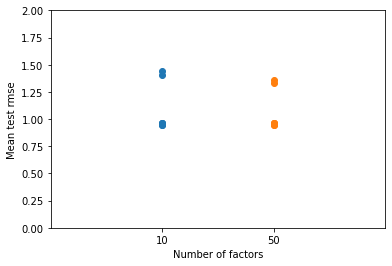

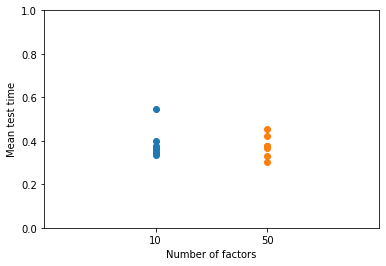

In [81]:
#Plot analysis of number of factors

plt.scatter(np.ones(int(len(results)/2)),results['mean_test_rmse'].iloc[:int(len(results)/2)])
plt.scatter(np.ones(int(len(results)/2))*2,results['mean_test_rmse'].iloc[int(len(results)/2):])
plt.ylabel('Mean test rmse')
plt.xlabel('Number of factors')
plt.axis([0, 3, 0, 2])
plt.xticks(ticks=[1, 2], labels=[10, 50])
plt.show()

plt.scatter(np.ones(int(len(results)/2)),results['mean_test_time'].iloc[:int(len(results)/2)])
plt.scatter(np.ones(int(len(results)/2))*2,results['mean_test_time'].iloc[int(len(results)/2):])
plt.ylabel('Mean test time')
plt.xlabel('Number of factors')
plt.axis([0, 3, 0, 1])
plt.xticks(ticks=[1, 2], labels=[10, 50])
plt.show()

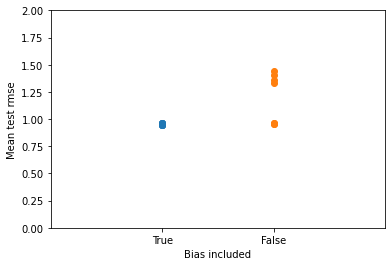

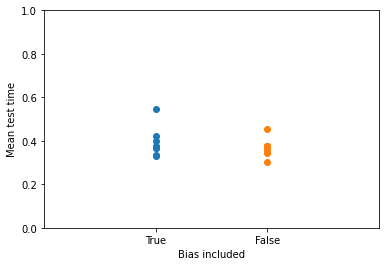

In [88]:
#Plot analysis on bias
r=results[['mean_test_rmse','param_biased']]

plt.scatter(np.ones(int(len(results)/2)),r[r['param_biased']==True]['mean_test_rmse'])
plt.scatter(np.ones(int(len(results)/2))*2,r[r['param_biased']==False]['mean_test_rmse'])
plt.ylabel('Mean test rmse')
plt.xlabel('Bias included')
plt.axis([0, 3, 0, 2])
plt.xticks(ticks=[1, 2], labels=['True', 'False'])
plt.show()

r=results[['mean_test_time','param_biased']]

plt.scatter(np.ones(int(len(results)/2)),r[r['param_biased']==True]['mean_test_time'])
plt.scatter(np.ones(int(len(results)/2))*2,r[r['param_biased']==False]['mean_test_time'])
plt.ylabel('Mean test time')
plt.xlabel('Bias included')
plt.axis([0, 3, 0, 1])
plt.xticks(ticks=[1, 2], labels=['True', 'False'])
plt.show()

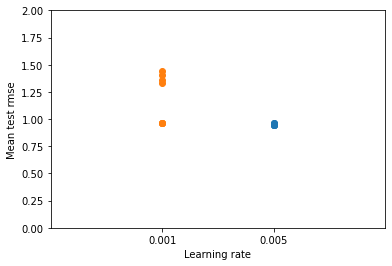

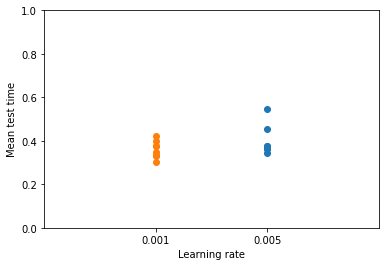

In [95]:
#Plot analysis on learning rate
r=results[['mean_test_rmse','param_lr_all']]

plt.scatter(np.ones(int(len(results)/2))*2,r[r['param_lr_all']==0.005]['mean_test_rmse'])
plt.scatter(np.ones(int(len(results)/2)),r[r['param_lr_all']!=0.005]['mean_test_rmse'])
plt.ylabel('Mean test rmse')
plt.xlabel('Learning rate')
plt.axis([0, 3, 0, 2])
plt.xticks(ticks=[1, 2], labels=[0.001, 0.005])
plt.show()

r=results[['mean_test_time','param_lr_all']]

plt.scatter(np.ones(int(len(results)/2))*2,r[r['param_lr_all']==0.005]['mean_test_time'])
plt.scatter(np.ones(int(len(results)/2)),r[r['param_lr_all']!=0.005]['mean_test_time'])
plt.ylabel('Mean test time')
plt.xlabel('Learning rate')
plt.axis([0, 3, 0, 1])
plt.xticks(ticks=[1, 2], labels=[0.001, 0.005])
plt.show()

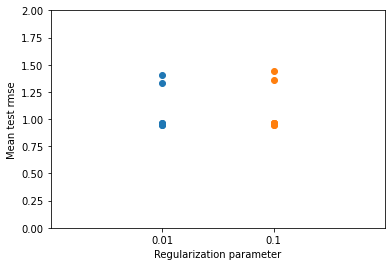

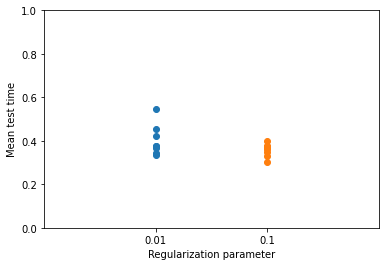

In [98]:
#Analysis 
r=results[['mean_test_rmse','param_reg_all']]

plt.scatter(np.ones(int(len(results)/2)),r[r['param_reg_all']==0.01]['mean_test_rmse'])
plt.scatter(np.ones(int(len(results)/2))*2,r[r['param_reg_all']!=0.01]['mean_test_rmse'])
plt.ylabel('Mean test rmse')
plt.xlabel('Regularization parameter')
plt.axis([0, 3, 0, 2])
plt.xticks(ticks=[1, 2], labels=[0.01, 0.1])
plt.show()

r=results[['mean_test_time','param_reg_all']]

plt.scatter(np.ones(int(len(results)/2)),r[r['param_reg_all']==0.01]['mean_test_time'])
plt.scatter(np.ones(int(len(results)/2))*2,r[r['param_reg_all']!=0.01]['mean_test_time'])
plt.ylabel('Mean test time')
plt.xlabel('Regularization parameter')
plt.axis([0, 3, 0, 1])
plt.xticks(ticks=[1, 2], labels=[0.01, 0.1])
plt.show()

As this algorithm is faster and more powerful than the one I built, I decided to use parameters that might take longer to train, but that will probably construct a better factorization. As it is shown in the graps, the mean RMSE in the test set is fairly good. A higher number of factors, including the bias and a learning rate of 0.005 contribute to generate a better model; however, some of these also may also increase the test time. I find very interesting that the values set as default for these parameters is pretty similar to the ones that generated the best results, so it is clear that this library is created to work with datasets similar to this one specifically. 
